# Imports

In [1]:
# Imports
import pickle
import numpy as np
from matplotlib.pyplot import cm
from matplotlib import pyplot as plt
from matplotlib import patches
from copy import deepcopy
import plotly.graph_objects as go
from scipy.optimize import curve_fit
from dataclasses import make_dataclass

import sys
module_path = 'code' 
if module_path not in sys.path:
    sys.path.append(module_path)
    
np.set_printoptions(threshold=sys.maxsize)


# Markus's code
from MM_Plot_Utils import plot, hist
from MM_Maze_Utils import *
from MM_Traj_Utils import *

%matplotlib inline
%reload_ext autoreload
%autoreload 2

# Initialize Data

In [2]:
UnrewNames=['B5','B6','B7','D3','D4','D5','D6','D7','D8','D9']
RewNames=['B1','B2','B3','B4','C1','C3','C6','C7','C8','C9']
UnrewNamesSub=['B5','B6','B7','D3','D4','D5','D7','D8','D9'] # excluding D6 which barely entered the maze
AllNames=RewNames+UnrewNames

# Helper Functions

## Maze and Trajectories

In [3]:
def ModeMask(tf,ma,re):
    '''
    Creates an array that parallels the bouts in tf giving the behavioral mode for every state
    0=home,1=drink,2=explore
    '''
    cl=SplitModeClips(tf,ma,re=True) # split the trajectory into mode clips
    ex=[np.zeros(len(b)) for b in tf.no] # list of arrays, one for each bout
    for c in cl: # for each clip
        ex[c[0]][c[1]:c[1]+c[2]]=c[3] # mark the states in the clip with the mode
    return ex

In [4]:
def NewTransMatrix(ma):
    '''
    Add node 127 to trans matrix
    '''
    tra = TransMatrix(ma)
    tra = np.append(tra,[[-1,0,0]],axis=0)
    return tra

## Initialization

A **state** is a tuple $(sn,sd)$ where $sn$ is the number of the state node, and $sd$ is the direction from which we have arrived to the state, as follows:
* 0: from parent
* 1: from left
* 2: from right

An **action** is a number indicating the action, as follows:
* 0: parent
* 1: left
* 2: right

The actions in the original code are numbered:
* 0: left
* 1: right
* 2: parent

$TranslateAction$ converts the original action codes to our action codes.

The action is viewed by the code as from state $(sn,0)$, in order to translate it to the action appropriate for the direction, we use $(sd + a) \text{ mod } 3$.

In [5]:
def TranslateAction(action):
    '''
    Translate action from original action code to our action code
    '''
    if (action == -1):
        return -1
    else:
        return (action + 1) % 3

In [6]:
def ConvertNodesToStatesActions(da,sta,ma):
    '''
    Convert node sequence to (state,action) format
    da = node list
    sta = node child matrix
    ma = maze
    '''
    newda=[(0,da[1])]
    for i,node in enumerate(da[1:],1):
        prevnode = da[i-1]
        nextnode = 0
        if i < len(da)-1:
            nextnode = da[i+1]
            
        nst = TranslateAction(StepType2(node, nextnode, ma)) # step type from MM_Maze_Utils
        
        state = node
        action = nst
        newda.append((state,action))
        
    return newda

$E$ matrix built as:
```
[
    [ # i = node number
        parent, left, right
    ]
]
```

In [7]:
def GetValue(E,state,action):
    '''
    return E(s,a)
    action = 0 - parent, 1 - left, 2 - right
    '''
    return E[state][action]

In [8]:
def FlattenHist(hist):
    '''
    Flatten hist where hist is an array of tuples (state,action) and return only state nodes
    '''
    return [x[0] for x in hist]

In [9]:
def FlattenBHist(hist):
    '''
    flatten bhist and return list of only state nodes with different array of nodes for each beta
    '''
    fhist = []
    for brow in hist[:,-1]:
        rhist = []
        for row in brow:
            rhist.extend(FlattenHist(row))
        fhist.append(rhist)
    return fhist

## New Nodes Visited

In [10]:
# Code from NewNodesMerge3 in MM_Traj_Utils
def NewNodes(hist_states,le):
    '''
    calculate number of new nodes visited in window
    hist_states = matrix of history
    le = window length
    '''
    en=list(range(2**le-1,2**(le+1)-1)) # list of node numbers in level le
    
    ce=np.array(hist_states, dtype="object") # concatenate all the bouts, only the nodes, not the times
    ei=np.where(np.isin(ce,en))[0] # index of all the desired node states
    
    if len(ei)>0: # if there is at least one state
        cn=np.copy(ce[ei]) # only the desired nodes
        lc=len(cn) # number of desired nodes encountered
        c=np.array([2,3,6,10,18,32,56,100,180,320,560,1000,1800,3200,5600,10000]) # window width in nodes
        c=c[np.where(c<lc)] # use only those shorter than full length
        c=np.append(c,lc) # add full length as last value
        n=[np.average(np.array([len(set(cn[j:j+c1])) for j in range(0,lc-c1+1,(lc-c1)//(lc//c1)+1)])) for c1 in c]
            # average number of distinct nodes in slightly overlapping windows of size w 
    else:
        w=np.array([]); c=np.array([]); n=np.array([])
        
    wcn=[np.array([]),c,n]
    return wcn

## Cross-Entropy

Cross-Entropy estimation for unknown source distribution calculated by:

$$ -\frac{1}{n} \sum_{i=1}^{n} \log_2 \pi(a_i | s_i) = \left\langle -\log_2 \pi(a_i | s_i) \right\rangle_i $$

where $n$ is the number of steps where $\pi(a_i | s_i) \neq 0$ and $\pi$ is the policy derived from the simulation.

In [11]:
def CalculateCrossEntropy(da,mk,pr,sta,ma):
    '''
    Calculate cross-entropy
    da = data
    mk = mask applied to action, Boolean
    pr = probability array
    sta = node child matrix
    ma = maze
    '''
    #ac=np.array([-1]+[StepType2(da[j-1],da[j],ma) for j in range(1,len(da))]) # forward actions
    acst = ConvertNodesToStatesActions(da,sta,ma)
    
    pt=[] # predicted probabilities for the observed action
    for i in range(len(da)): # i points to the action to be predicted
        if mk[i]:
            x = acst[i]
            sn = x[0]
            a = x[1]
            pt+=[pr[sn][a]] # add probability for the observed action to the list
    
    pt = np.array(pt)
    #pts = pt[pt!=0] # pt support
    #print(pts)
    #ce=-np.sum(np.log2(pts))/len(pts) # cross-entropy
    ce=-np.sum(np.log2(pt, out=-np.ones_like(pt), where=(pt!=0)))/len(pt) # cross-entropy
    
    return ce

Calculate cross-entropy between two policies by:
$$ -\frac{1}{|S|} \sum_{(s,a) \in \mathcal{S} \times \mathcal{A}} \pi_1(s,a) \log_2 \pi_2(s,a) $$
where $\mathcal{S}$ is the set of states (from 0 to 126), $\mathcal{A}$ is the set of actions for each state (from 0 to 2), and $\pi_1,\pi_2$ are two policies derived from two seperate simulations. 

In [12]:
def CalculateCrossEntropy2P(p1,p2):
    '''
    Calculate cross-entropy between two policies
    p1,p2 = two policies of the same shape SxA
    '''
    ce=-np.sum(p1 * np.log2(p2, out=np.zeros_like(p2), where=(p2!=0)))/np.shape(p1)[0]
    
    return ce

# Initialize Maze

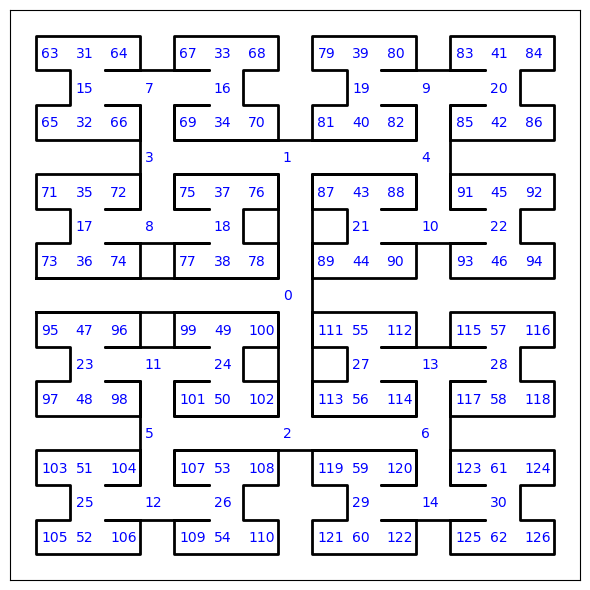

In [13]:
ma=NewMaze(6)
PlotMazeNodes(ma)

## Globals

In [14]:
terminals = np.arange(63,127)
terminal_mat = [1,0,0]
home_mat = [0,1/2,1/2]

# Main Functions

## Helpers

## Initialize

Policy defined as:

$$\pi(a|s) = \frac{e^{\beta E(s,a)}}{\sum_{a'}e^{\beta E(s,a')}}$$

$policy$ matrix shape is the same as E matrix shape (above).

$sta$ built as:
```
[
    [ # i = node number
        # node level (127 = home, 0 = 1,2 etc.)
        # left child node number
        # right child node number
    ]
]
```

In [371]:
NewTransMatrix(ma) # = sta

array([[127,   1,   2],
       [  0,   3,   4],
       [  0,   6,   5],
       [  1,   8,   7],
       [  1,   9,  10],
       [  2,  12,  11],
       [  2,  13,  14],
       [  3,  15,  16],
       [  3,  18,  17],
       [  4,  19,  20],
       [  4,  22,  21],
       [  5,  23,  24],
       [  5,  26,  25],
       [  6,  27,  28],
       [  6,  30,  29],
       [  7,  32,  31],
       [  7,  33,  34],
       [  8,  36,  35],
       [  8,  37,  38],
       [  9,  40,  39],
       [  9,  41,  42],
       [ 10,  44,  43],
       [ 10,  45,  46],
       [ 11,  48,  47],
       [ 11,  49,  50],
       [ 12,  52,  51],
       [ 12,  53,  54],
       [ 13,  56,  55],
       [ 13,  57,  58],
       [ 14,  60,  59],
       [ 14,  61,  62],
       [ 15,  63,  64],
       [ 15,  66,  65],
       [ 16,  67,  68],
       [ 16,  70,  69],
       [ 17,  71,  72],
       [ 17,  74,  73],
       [ 18,  75,  76],
       [ 18,  78,  77],
       [ 19,  79,  80],
       [ 19,  82,  81],
       [ 20,  83

In [15]:
def Init(beta):
    '''
    initialize simulation, return E and policy matrix, and sta = matrix of nodes and their children.
    '''
    sta=NewTransMatrix(ma) # array of nodes connected to each node as such: index = parent node, [level, left child, right child]
    E=np.ones((len(ma.ru)+1,3)) # 2D array of values
    policy = np.full(E.shape,1/3)
    policy[terminals] = terminal_mat # reset terminal matrices
    policy[-1] = home_mat # reset home matrix
    return E,policy,sta

## Simulation Functions

Update E by:
$$ E(s,a) \leftarrow E(s,a) + \eta \left(-E(s,a) + \gamma E(s',a')\right) $$

In [16]:
def UpdateEAndPolicy(E,policy,state0,action0,value1,beta,gamma,eta):
    '''
    Updates the E and policy matrix. If beta > 700, assume beta=infinity
    state0 = node
    action0 = 0 - parent, 1 - left, 2 - right
    value1 = E(s',a')
    '''
    value0 = GetValue(E,state0,action0) # get E(s,a)
    E[state0][action0] += eta * (-value0 + gamma * value1) # update E(s,a)
    # update policy
    if beta <= 700:
        exp_beta_E=np.exp(E * beta)
        policy=np.divide(exp_beta_E, exp_beta_E.sum(axis=1,keepdims=True), out=np.zeros_like(exp_beta_E), where=exp_beta_E.sum(axis=1,keepdims=True)!=0)
        policy[terminals] = terminal_mat # reset terminal matrices
        policy[-1] = home_mat # reset home matrix
    else: # beta = infinity
        m = max(E[state0])
        mi = np.where(E[state0] == m)[0]
        policy[state0,:] = 0
        policy[state0][mi] = 1/len(mi)
    
    return E,policy

In [17]:
def ChooseAction(policy,state):
    '''
    choose next action by policy probabilities. returns **translated action**
    '''
    return int(np.random.choice(3,1,p=policy[state])[0])

$hist$ matrix built as:
```
[
    [ # i = number of bout
        (state, ta)
    ]
]
```
With $state=(sn,sd)$ and $ta$ is the translated action.

In [18]:
def Simulate(nbouts,E,policy,sta,beta=0.1,gamma=0.1,eta=0.1):
    '''
    simulate trajectories and return final E and policy matrices, and history
    nbouts = number of bouts (exploration until back to cage)
    E = E matrix
    policy = policy matrix
    sta = parents and children matrix
    '''
    hist = []
    state0 = 0
    action0 = ChooseAction(policy,state0)
    for i in range(nbouts):
        hist.append([])
        home = False # has the bout ended
        hist[i].append((state0,action0))
        while not home:
            state1 = sta[state0][action0] # state1 = next state node
            action1 = ChooseAction(policy,state1)
            value1 = GetValue(E,state1,action1) # get E(s',a')
            E,policy = UpdateEAndPolicy(E,policy,state0,action0,value1,beta,gamma,eta)
            state0 = state1
            action0 = action1
            if state1 == 127: # back to cage
                home = True
            else:
                hist[i].append((state0,action0))
            
    return E, policy, hist

# End Nodes Visited

## Run Simulation

In [275]:
eta=0.1
gamma=0.1
betas = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 100]

nbouts = 100

bhist = np.ndarray(shape=(len(betas),2), dtype=object)
bhist[:,0] = betas

for j,beta in enumerate(betas): # run simulation on each beta
    E,policy,sta = Init(beta)
    E,policy,hist = Simulate(nbouts,E,policy,sta,beta,gamma,eta)
    bhist[j,-1] = hist

## Play With Beta=100

In [281]:
# BETA = 100

nbouts = 100
beta=800
betas[-1] = 'infinity'
bhist[:,0] = betas
E,policy,sta = Init(beta)
E,policy,hist = Simulate(nbouts,E,policy,sta,beta,gamma,eta)
bhist[-1,-1] = hist


In [147]:
_,_,hist = Simulate(1,E,policy,sta,beta,gamma,eta)
print(policy)

[[0.55462541 0.22683901 0.21853558]
 [0.34804536 0.3291838  0.32277084]
 [0.33801774 0.32727089 0.33471137]
 [0.32445293 0.32325113 0.35229594]
 [0.32160377 0.34189406 0.33650217]
 [0.30788552 0.35460923 0.33750525]
 [0.33735481 0.3289042  0.33374099]
 [0.31345997 0.32615045 0.36038959]
 [0.34317467 0.33238474 0.3244406 ]
 [0.33385433 0.34076219 0.32538349]
 [0.33497892 0.3456816  0.31933948]
 [0.33372383 0.31772655 0.34854962]
 [0.34772317 0.32196056 0.33031627]
 [0.33410475 0.33842395 0.3274713 ]
 [0.33583358 0.3319132  0.33225322]
 [0.35207155 0.32774405 0.32018441]
 [0.3440487  0.31235993 0.34359137]
 [0.33082903 0.34188061 0.32729036]
 [0.331324   0.33241088 0.33626512]
 [0.31784803 0.35380991 0.32834206]
 [0.33530142 0.33004288 0.3346557 ]
 [0.33052051 0.34182378 0.32765571]
 [0.3319376  0.33187608 0.33618632]
 [0.32900135 0.32881274 0.34218592]
 [0.30888116 0.36133888 0.32977996]
 [0.30346172 0.32392105 0.37261723]
 [0.33208745 0.31204351 0.35586904]
 [0.31981966 0.36143567 0.31

## Plot End Nodes Visited

(1, 5000)

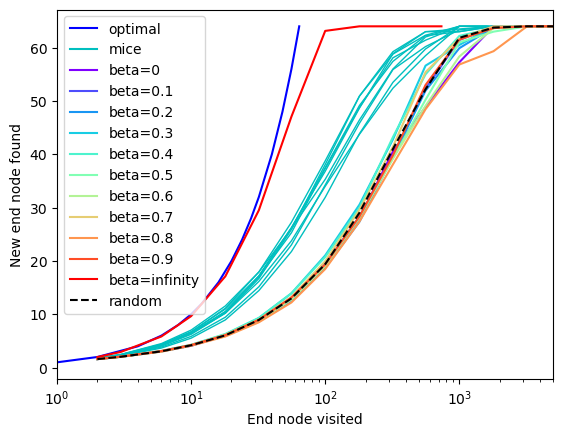

In [282]:
le=6 # end nodes level

# PLOT OPTIMAL
x=[1,2,4,6,8,10,12,16,20,24,28,32,40,48,56,64]
y=[1,2,4,6,8,10,12,16,20,24,28,32,40,48,56,64] 
fig, ax = plt.subplots()
ax.set_xscale('log')
ax.plot(x,y,'-b',label='optimal')

# PLOT UNREWARDED MICE
for i,nickname in enumerate(UnrewNamesSub):
    with open('outdata/'+nickname+'-Modes1', 'rb') as f:
        nn1,nf1,tr1,wcn=pickle.load(f)
    x=wcn[1,:]
    y=wcn[2,:]
    ax.plot(x,y,'-c',linewidth=1)
plt.plot([], [], 'c', label="mice")

# PLOT SIMULATION
fhist = FlattenBHist(bhist) # flattened bhist
color = cm.rainbow(np.linspace(0, 1, len(betas)))

for i,row in enumerate(fhist):
    wcn = NewNodes(row,le)
    x=wcn[1]
    y=wcn[2]
    ax.plot(x,y,c=color[i], label='beta=' + str(bhist[i,0]))
    
# PLOT RANDOM
tf=LoadTraj('rw01-tf')
wcn=NewNodesMerge3(tf,ma,le)
x=wcn[1,:]
y=wcn[2,:]
ax.plot(x,y,'--k', linewidth=1.5,label='random')

ax.legend()
ax.set_xlabel('End node visited')
ax.set_ylabel('New end node found')
ax.set_xlim([1,5000])


# Cross-Entropy

## Calculate cross-entropy for each unrewarded mouse

In [19]:
eta=0.1
gamma=0.1
beta=100
nbouts=100

E,policy,sta = Init(beta)
E,policy,hist = Simulate(nbouts,E,policy,sta,beta,gamma,eta)

In [291]:
print(policy)

[[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1.

In [20]:
rew = False

unrew_ce = []
for nickname in UnrewNamesSub:
    tf=LoadTraj(nickname+'-tf')
    ex=ModeMask(tf,ma,rew) # one array for each bout marking states with mode = 0,1,2
    dte=np.concatenate([b[:-2,0] for b in tf.no]) # test states
    mte=np.array([False]+[True,]*(len(dte)-1)) # mask for testing, all actions OK except first
    mte[np.where(dte[:-1]>62)[0]]=False # mask for testing, eliminate end nodes
    ce = CalculateCrossEntropy(dte,mte,policy,sta,ma)
    unrew_ce.append(ce)

## Plot Cross-Entropy

In [21]:
with open('outdata/Markov3-TJ1-EX1-Split5-LevelsLR', 'rb') as f:
    Names,ef,hf,ev,hv,eft,hft,evt,hvt=pickle.load(f) 

In [22]:
all_ce = []
for _,name in enumerate(Names):
    if name not in UnrewNamesSub:
        all_ce.append(0)
    else:
        all_ce.append(unrew_ce[UnrewNamesSub.index(name)])

In [23]:
# Table of entropies from all methods for TJs and exploration
with open('outdata/BZentropies', 'rb') as f:
    _,en=pickle.load(f)  
with open('outdata/FixEntropies-TJ1-EX1-Split5-LevelsLR', 'rb') as f:
    _,ef=pickle.load(f)  
with open('outdata/VarEntropies-TJ1-EX1-Split5-LevelsLR', 'rb') as f:
    _,ev=pickle.load(f)  
with open('outdata/FourBiasEntropies-TJ1-EX1-Split5', 'rb') as f:
    _,eb=pickle.load(f) 
    
print('Entropy from Markov fits and 4-bias walk')
print('Restricted to T-junctions and exploration mode')
print('Markov fits pool over L vs R nodes in each level')
print('   fixed Markov  variable Markov  4-bias walk        Model')
for i in range(len(Names)):
    print(Names[i]+':    {:5.3f}           {:5.3f}          {:5.3f}          {:5.3f}'.
          format(ef[i],ev[i],eb[i],all_ce[i]))
print('------------------------------------------------------------')
print('Av:    {:5.3f}           {:5.3f}          {:5.3f}          {:5.3f}'.
      format(np.mean(ef),np.mean(ev),np.mean(eb),np.mean(unrew_ce)))
print('SD:    {:5.3f}           {:5.3f}          {:5.3f}          {:5.3f}'.
      format(np.std(ef),np.std(ev),np.std(eb),np.std(unrew_ce)))

Entropy from Markov fits and 4-bias walk
Restricted to T-junctions and exploration mode
Markov fits pool over L vs R nodes in each level
   fixed Markov  variable Markov  4-bias walk        Model
B1:    1.250           1.243          1.414          0.000
B2:    1.277           1.267          1.470          0.000
B3:    1.222           1.214          1.422          0.000
B4:    1.262           1.231          1.495          0.000
C1:    1.220           1.210          1.446          0.000
C3:    1.183           1.168          1.436          0.000
C6:    1.196           1.191          1.379          0.000
C7:    1.234           1.218          1.444          0.000
C8:    1.211           1.191          1.489          0.000
C9:    1.238           1.229          1.460          0.000
B5:    1.294           1.278          1.458          1.589
B6:    1.270           1.259          1.491          1.589
B7:    1.286           1.267          1.486          1.588
D3:    1.286           1.275         

Limited to T-junctions during exploration, includes L vs R node pooling


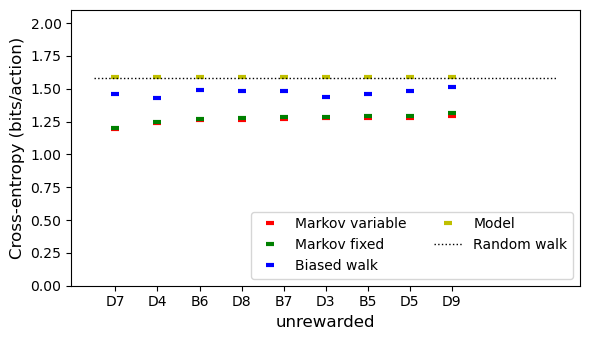

In [24]:
k=len(RewNames)
RN=np.array(RewNames)
UN=np.array(UnrewNamesSub)
ev=np.array(ev);ef=np.array(ef);eb=np.array(eb);en=np.array(en);ace=np.array(all_ce)
evr=ev[:k];efr=ef[:k];ebr=eb[:k];enr=en[:k]
evu=ev[k:];efu=ef[k:];ebu=eb[k:];enu=en[k:];aceu=ace[k:]
sir=np.argsort(evr)
siu=np.argsort(evu)
print('Limited to T-junctions during exploration, includes L vs R node pooling')
ax=plot(np.arange(len(UN)),[evu[siu],efu[siu],ebu[siu],aceu[siu]],
    fmts=['r_','g_','b_','y_'],markersize=6,markeredgewidth=3,
       figsize=(6,3.5),xlabel='unrewarded',ylabel='Cross-entropy (bits/action)');
plot([-0.5,len(UN)+1.5],[np.log(3)/np.log(2),np.log(3)/np.log(2)],
    fmts=['k:'],linewidth=1,ylim=[0,2.1],axes=ax);
plt.legend(['Markov variable','Markov fixed','Biased walk','Model','Random walk'],loc='lower right',ncol=2)
plt.xticks(list(np.arange(len(UN))),list(UN[siu]));

## Calculate cross-entropy between two simulations

In [25]:
eta=0.1
gamma=0.1
beta=600
nbouts=100

# sim 1
E1,policy1,sta = Init(beta)
E1,policy1,hist1 = Simulate(nbouts,E1,policy1,sta,beta,gamma,eta)

# sim 2
E2,policy2,_ = Init(beta)
E2,policy2,hist2 = Simulate(nbouts,E2,policy2,sta,beta,gamma,eta)

print(CalculateCrossEntropy2P(policy1,policy2))
print(CalculateCrossEntropy2P(policy1,policy1))
print(CalculateCrossEntropy2P(policy2,policy2))


0.7974775992492363
0.7815451158666329
0.7778066382473241


In [154]:
print(-np.log2(1/(126*3)))

8.562242424221072
